### 1- Creating the probe geometry dictionary

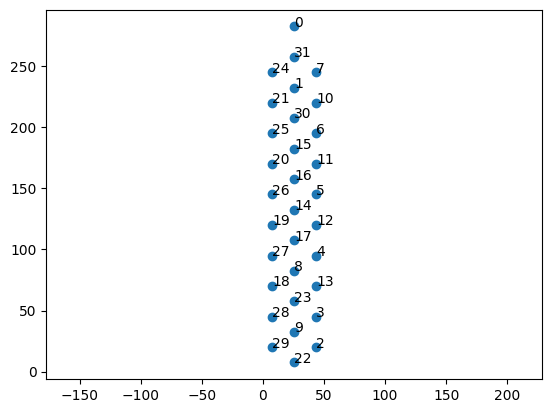

In [32]:
# Refer to https://kilosort.readthedocs.io/en/latest/tutorials/make_probe.html for the original example
import numpy as np
import matplotlib.pyplot as plt
n_chan = 32
chanMap = np.arange(n_chan) # assuming all channels are used -- change this accordingly
kcoords = np.zeros(n_chan) # shank or channel group of each contact (assuming a single shank here)

# Layout of a NeuroNexus probe (A1x32-Poly3-5 mm-25s-177-CM32 with 32 electrodes in three columns and hexagonal arrangement:
# a x-pitch and y-pitch of 18 and 22 mm, respectively, and an electrode radius of 7.5 mm)

# more info/example with Neuronexus 16 chan here: https://github.com/MouseLand/Kilosort/issues/622

# https://github.com/alejoe91/MEAutility/blob/master/MEAutility/electrodes/Neuronexus-32.yaml
# https://github.com/dervinism/geometricLayout/blob/master/mapPipeline_CM32_A1x32_Poly3_5mm_25s_177.m


# Since the contacts are 15 micrometers wide (x) and 15 micrometers high (y), 
# our first contact center has coordinates (7.5, 7.5). 
# There are 3 columns of contacts (18 micrometers apart), and 10,12,10 sites per column, resp.
# Finally, the diagram indicates that contacts are spaced 25 micrometers apart vertically,
# and that the middle column is shifted 12.5 micrometers down relative to the other two.

xc_col =  np.ones(12)*7.5# the x-coordinates (in micrometers) of the probe contact centers.
chans_per_col = [24,21,25,20,26,19,27,18,28,29] +\
                    [0, 31, 1, 30, 15, 16, 14, 17, 8, 23, 9, 22] +\
                    [7, 10, 6, 11, 5, 12, 4, 13, 3, 2]
xc = np.concatenate([xc_col[2:], xc_col + 18, xc_col[2:] + 2*18])

idxs = np.argsort(chans_per_col)
xc = xc[idxs]
yc_col = np.arange(12)[::-1]*25 + 7.5
yc = np.concatenate([yc_col[2:] + 12.5, yc_col, yc_col[2:] + 12.5])
yc = yc[idxs]
chans_per_col = np.array(chans_per_col)[idxs]
plt.scatter(xc, yc)
plt.axis('equal')
for x,y,c in zip(xc, yc, chans_per_col):
    plt.text(x, y, str(c))

In [40]:
probe = {
    'chanMap': chanMap,
    'xc': xc,
    'yc': yc,
    'kcoords': kcoords,
    'n_chan': n_chan
}
# provide the resulting dictionary to kilosort.run_kilosort using the probe keyword argument :
# results = run_kilosort(..., probe=probe)

### 2 - Load the extracellular raw data from the Neto et al. dataset

In [58]:
data_folder = '2014_11_13_Pair_3_0'
Sampling_frequency = 30_000  #Hz
Probe_numChannels = 32
Probe_dtype = np.uint16
Probe_voltage_step_size = 0.195e-6
Probe_y_digitization = 32768
Juxta_numChannels = 8
Juxta_dtype = np.uint16
Juxta_ADC_used_channel = 0
Juxta_Gain = 100
Juxta_y_digitization = 65536
Juxta_y_range = 10
distance_min = 172 #(µm) 
Probe_closest_electrode = 17


# Load data from bin files into a matrix of n channels x m samples 
def loadRawData(filename, numChannels, dtype):
    
    fdata = np.fromfile(filename,dtype=dtype)
    assert len(fdata) % numChannels == 0
    numsamples = len(fdata) // numChannels
    data = np.reshape(fdata,(numsamples, numChannels))
    
    return data # (# samples, # channels) <-- this is the shape required by kilosort

# Open Amplifier file 
from scipy import signal
# (extracellular recording from a silicon polytrode with 32 or 128 electrodes -- frequency band from 0.1 to 7500 Hz)

filename = f"{data_folder}/amplifier2014-11-13T18_48_11.bin"
extra = loadRawData(filename, numChannels = Probe_numChannels, dtype = Probe_dtype) 

extra_milliVolts = 1000 * (extra - Probe_y_digitization) * Probe_voltage_step_size
extra_milliVolts = extra_milliVolts.astype('float32')

In [59]:
extra_milliVolts.dtype

dtype('float32')

In [62]:
extra_milliVolts.shape

(7842600, 32)

In [61]:
# total recording time in secs
extra_milliVolts.shape[0] / Sampling_frequency

261.42

In [64]:
extra.dtype

dtype('uint16')

### 2 - Running kilo

In [45]:
from kilosort import run_kilosort, DEFAULT_SETTINGS

In [ ]:
# We can pass the `extra_milliVolts` numpy array directly to kilosort:

# file_object : array-like file object; optional.
#     Must have 'shape' and 'dtype' attributes and support array-like
#     indexing (e.g. [:100,:], [5, 7:10], etc). For example, a numpy
#     array or memmap. Must specify a valid `filename` as well, even though
#     data will not be directly loaded from that file.



In [65]:
settings = DEFAULT_SETTINGS

# path_to_file = #? do we need to convert the raw data file first? no, see above cell. 

settings['data_dir'] = '/Users/dyballa/repos/TempoSort/data/2016_rat_cortex_Neto_et_al/' # where the outputs files will be saved
settings['n_chan_bin'] = n_chan
settings['tmax'] =  5# secs
ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = \
    run_kilosort(settings=settings, filename=data_folder, data_dtype=extra.dtype, file_object=extra, probe=probe)

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: macOS-13.7-x86_64-i386-64bit x86_64
kilosort.run_kilosort: i386
kilosort.run_kilosort: Using CPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting 2014_11_13_Pair_3_0
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 150000
kilosort.run_kilosort: N seconds: 5.0
kilosort.run_kilosort: N batches: 3
kilosort.run_kilosort: Preprocessing filters computed in  2.13s; total  2.17s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilo

In [66]:
import numpy as np
import pandas as pd
from pathlib import Path

# outputs saved to results_dir
results_dir = Path(settings['data_dir']).joinpath('kilosort4')
ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

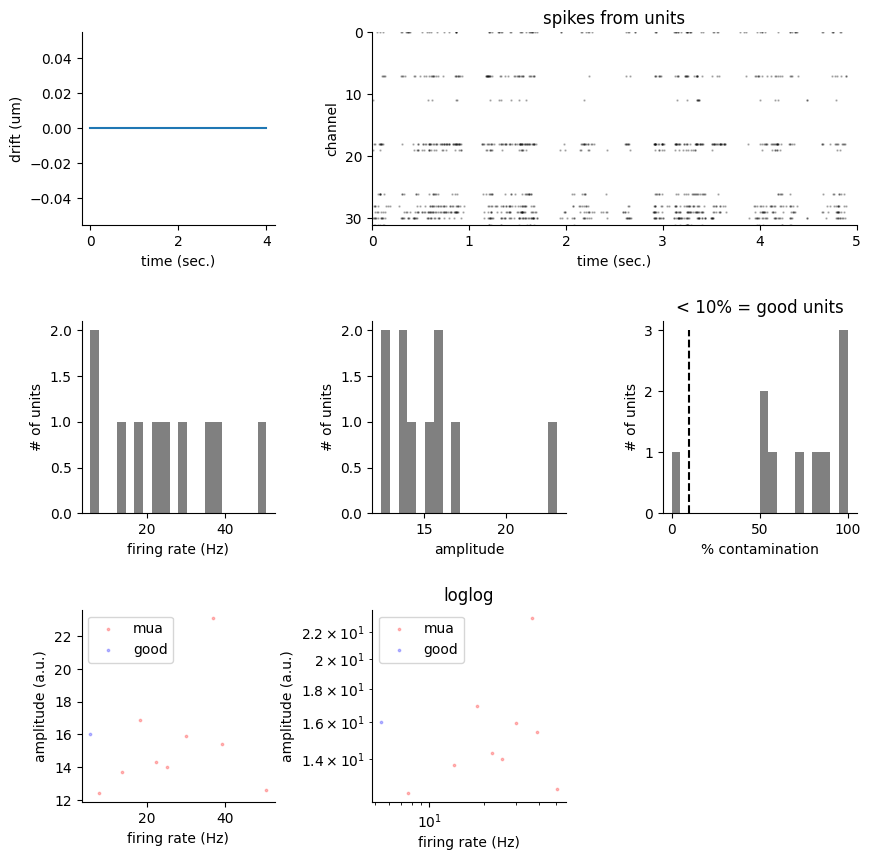

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*4.9)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

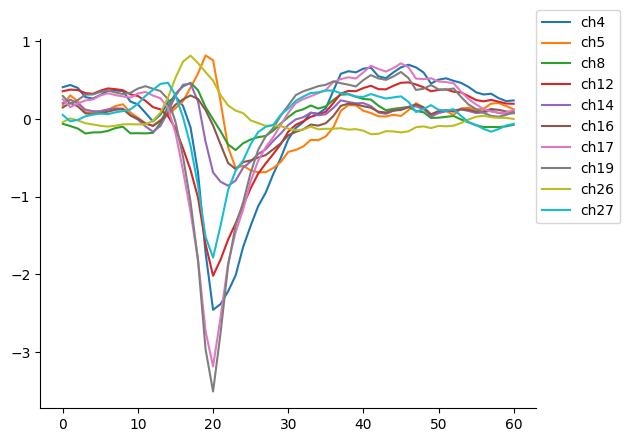

In [74]:
from pathlib import Path
import matplotlib.pyplot as plt
results_dir = Path(settings['data_dir']).joinpath('kilosort4')
templates =  np.load(results_dir / 'templates.npy')

templi = 3 #choose a given template

# these show the waveforms for several channels in a given template (channels not considered are zeroed)
# templates.shape (#template, #time pts, #num good channels)


which_chans = []
for i in range(n_chan): #plot the waveform from each channel participating in that template
    if abs(templates[templi,:,i]).sum() > 0:
        which_chans.append(chan_map[i]) #convert the channel index (0--373) to the global index (0--384, the full probe)
        plt.plot(templates[templi,:,i], label=f'ch{i}');
plt.legend(loc=(1,.5))
plt.show()

assert np.all(which_chans == np.flatnonzero(abs(templates[templi]).sum(0) > 0))

In [ ]:
# channel 17 is one of the strongest channels in template 3 --> might well be our juxta neuron ?